# Global Housing Market Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
import xgboost as xgb

In [2]:
# Set plot style
sns.set_style("whitegrid")

In [3]:
data = pd.read_csv('global_housing_market_extended.csv')
# data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data.head()

,Country,Year,House Price Index,Rent Index,Affordability Ratio,Mortgage Rate (%),Inflation Rate (%),GDP Growth (%),Population Growth (%),Urbanization Rate (%),Construction Index
0,USA,2015,117.454012,116.550001,9.587945,4.493292,1.514121,-0.752044,-0.796707,85.985284,118.089201
1,USA,2016,150.807258,51.440915,11.729189,5.662213,1.880204,-0.545400,-0.358084,69.127267,111.980515
2,USA,2017,123.194502,70.386040,8.506676,2.197469,2.398940,0.930895,0.596245,83.555279,85.973903
3,USA,2018,131.423444,91.469020,3.418054,4.537724,1.608407,-1.479587,2.321099,88.968961,134.671788
4,USA,2019,110.461377,56.837048,9.158097,3.700762,1.293249,1.961415,-0.879640,87.279612,90.702399


In [6]:
data.shape

(200, 11)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                200 non-null    object 
 1   Year                   200 non-null    int64  
 2   House Price Index      200 non-null    float64
 3   Rent Index             200 non-null    float64
 4   Affordability Ratio    200 non-null    float64
 5   Mortgage Rate (%)      200 non-null    float64
 6   Inflation Rate (%)     200 non-null    float64
 7   GDP Growth (%)         200 non-null    float64
 8   Population Growth (%)  200 non-null    float64
 9   Urbanization Rate (%)  200 non-null    float64
 10  Construction Index     200 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 17.3+ KB


# Exploratory Data Analysis

## Trends & Patterns Over Time

-  Price Index & Rent Index Trends: Analyze how house prices and rent have changed from 2015 to 2024 globally and per country.
- Affordability Ratio Trends: Investigate whether housing has become more or less affordable over time.
- Mortgage Rate & Inflation Impact: Examine how mortgage rates and inflation rates have fluctuated and their impact on house prices.

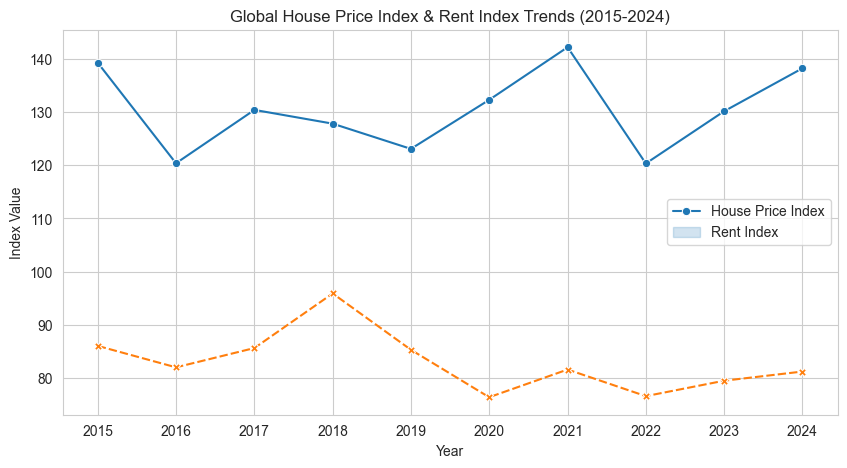

In [7]:
# House Price Index & Rent Index Trends (Globally)
global_trends = data.groupby("Year")[['House Price Index', 'Rent Index']].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(data=global_trends, markers=True)
plt.title("Global House Price Index & Rent Index Trends (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.legend(["House Price Index", "Rent Index"])
plt.show()

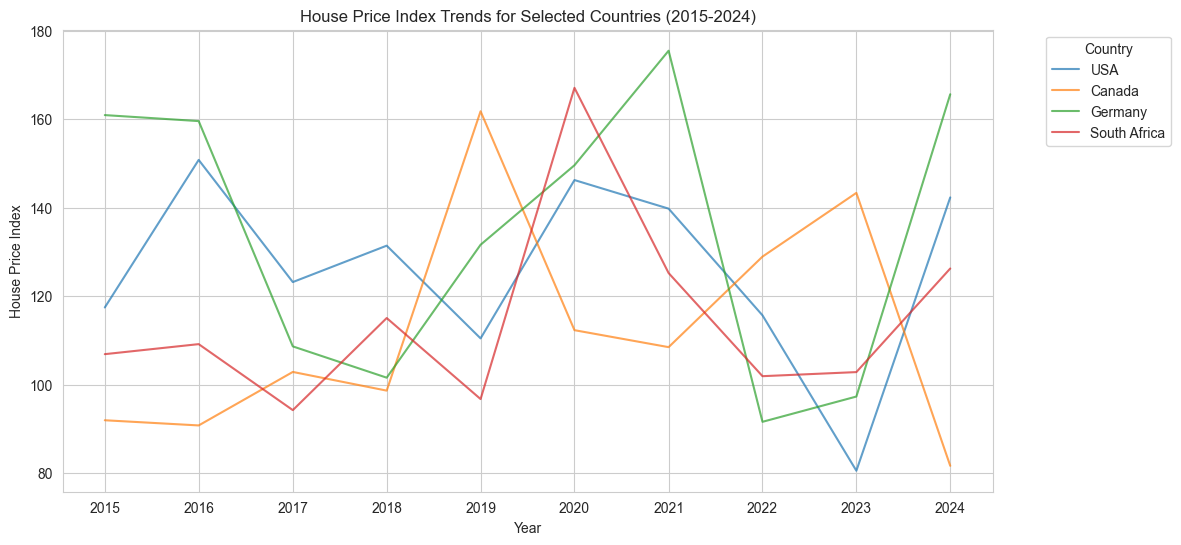

In [8]:
# House Price Index & Rent Index Trends (Per Selected Countries)
selected_countries = ["USA", "Canada", "Germany", "South Africa"]  # Modify this list as needed
filtered_df = data[data['Country'].isin(selected_countries)]
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_df, x='Year', y='House Price Index', hue='Country', alpha=0.7)
plt.title("House Price Index Trends for Selected Countries (2015-2024)")
plt.xlabel("Year")
plt.ylabel("House Price Index")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

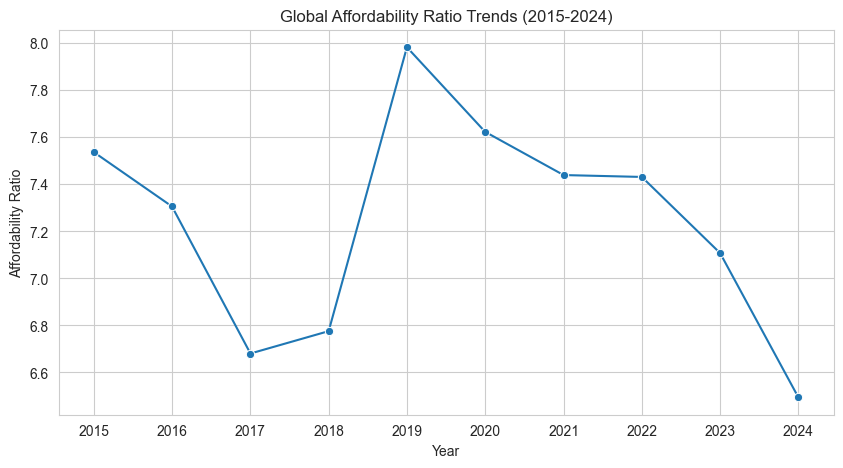

In [10]:
# Affordability Ratio Trends Over Time
affordability_trends = data.groupby("Year")['Affordability Ratio'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=affordability_trends.index, y=affordability_trends.values, marker="o")
plt.title("Global Affordability Ratio Trends (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Affordability Ratio")
plt.show()

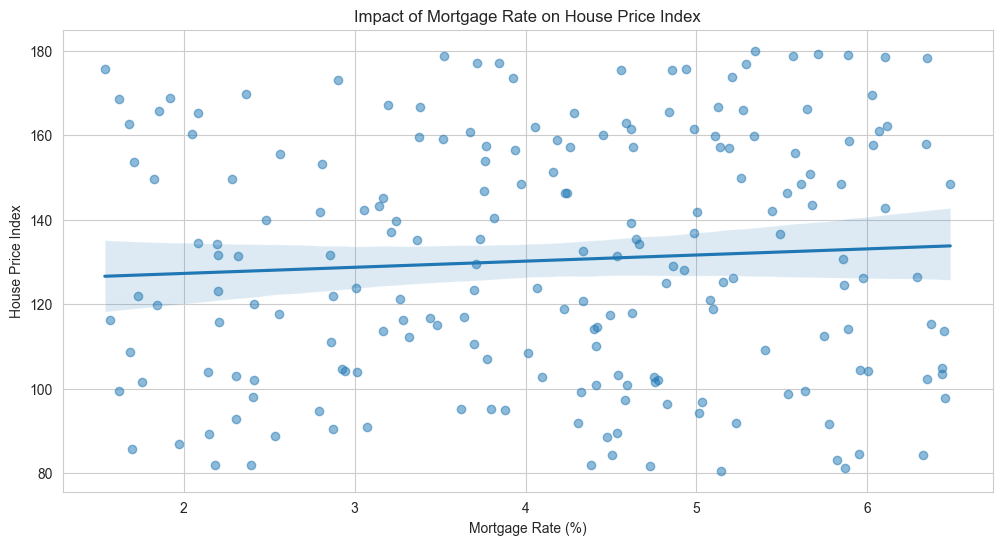

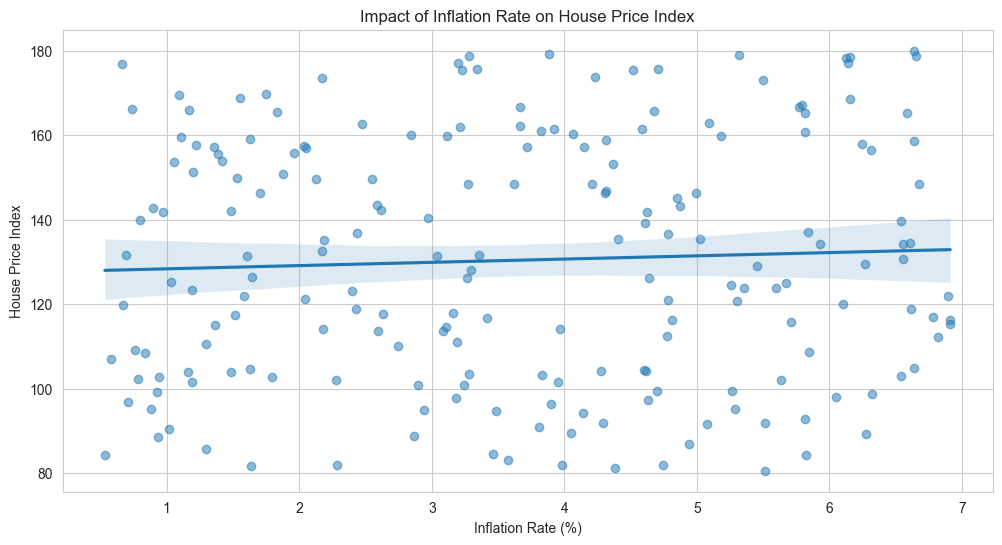

In [11]:
# Mortgage Rate & Inflation Impact on House Prices
plt.figure(figsize=(12, 6))
sns.regplot(x=data['Mortgage Rate (%)'], y=data['House Price Index'], scatter_kws={'alpha':0.5})
plt.title("Impact of Mortgage Rate on House Price Index")
plt.xlabel("Mortgage Rate (%)")
plt.ylabel("House Price Index")
plt.show()

plt.figure(figsize=(12, 6))
sns.regplot(x=data['Inflation Rate (%)'], y=data['House Price Index'], scatter_kws={'alpha':0.5})
plt.title("Impact of Inflation Rate on House Price Index")
plt.xlabel("Inflation Rate (%)")
plt.ylabel("House Price Index")
plt.show()

## Country-Level Analysis
- Country Comparisons: Countries with the highest/lowest house price growth.
- Urbanization vs. Housing Market
- Economic Growth Impact

C:\Users\User\AppData\Local\Temp\ipykernel_4136\2415793321.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5.index, y=top_5.values, palette='viridis')


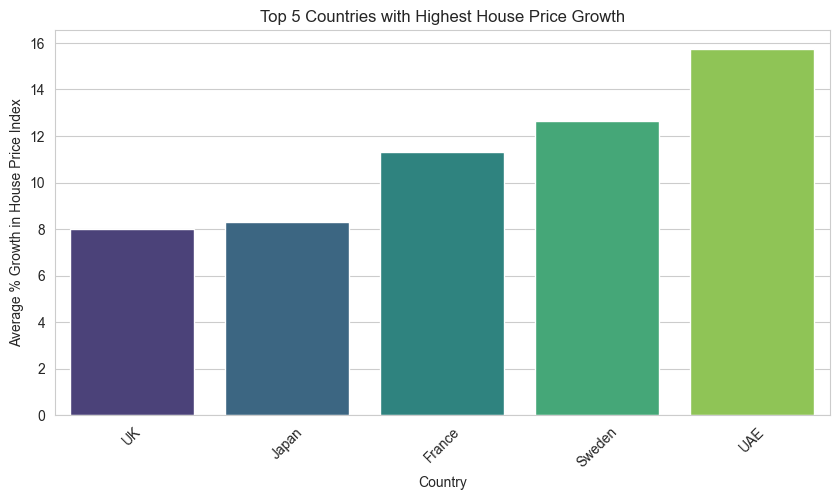

C:\Users\User\AppData\Local\Temp\ipykernel_4136\2415793321.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_5.index, y=bottom_5.values, palette='coolwarm')


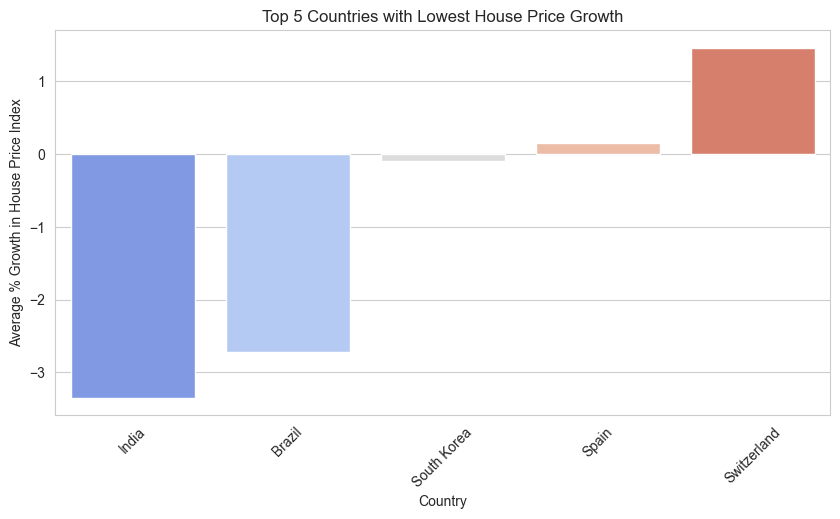

In [12]:
# Countries with Highest/Lowest House Price Growth
data['Price Growth'] = data.groupby('Country')['House Price Index'].pct_change() * 100
growth_summary = data.groupby('Country')['Price Growth'].mean().dropna().sort_values()

# Top and Bottom 5 Countries
top_5 = growth_summary.tail(5)
bottom_5 = growth_summary.head(5)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_5.index, y=top_5.values, palette='viridis')
plt.title("Top 5 Countries with Highest House Price Growth")
plt.xlabel("Country")
plt.ylabel("Average % Growth in House Price Index")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=bottom_5.index, y=bottom_5.values, palette='coolwarm')
plt.title("Top 5 Countries with Lowest House Price Growth")
plt.xlabel("Country")
plt.ylabel("Average % Growth in House Price Index")
plt.xticks(rotation=45)
plt.show()

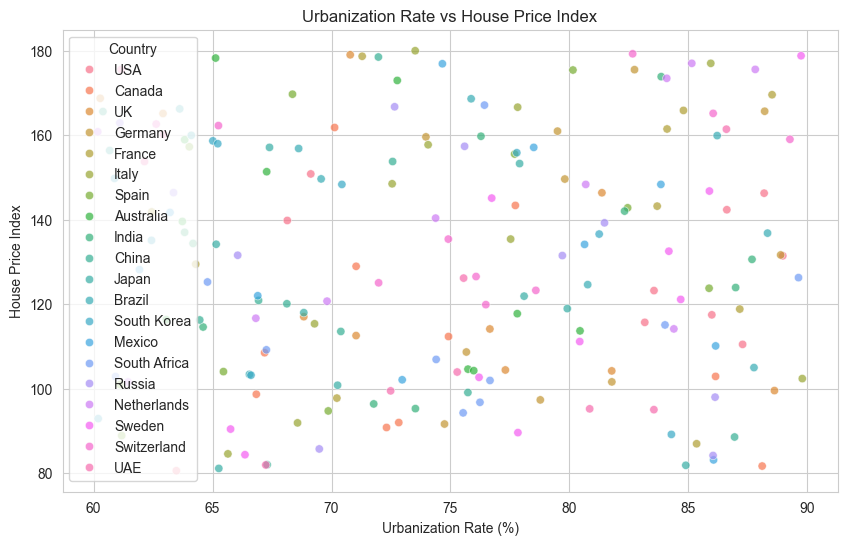

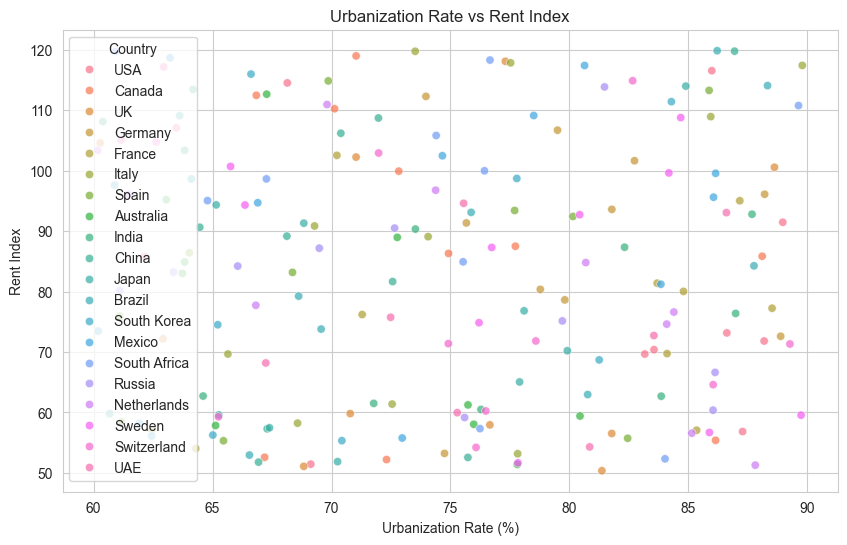

In [13]:
# Urbanization vs. Housing Market
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Urbanization Rate (%)', y='House Price Index', hue='Country', alpha=0.7)
plt.title("Urbanization Rate vs House Price Index")
plt.xlabel("Urbanization Rate (%)")
plt.ylabel("House Price Index")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Urbanization Rate (%)', y='Rent Index', hue='Country', alpha=0.7)
plt.title("Urbanization Rate vs Rent Index")
plt.xlabel("Urbanization Rate (%)")
plt.ylabel("Rent Index")
plt.show()

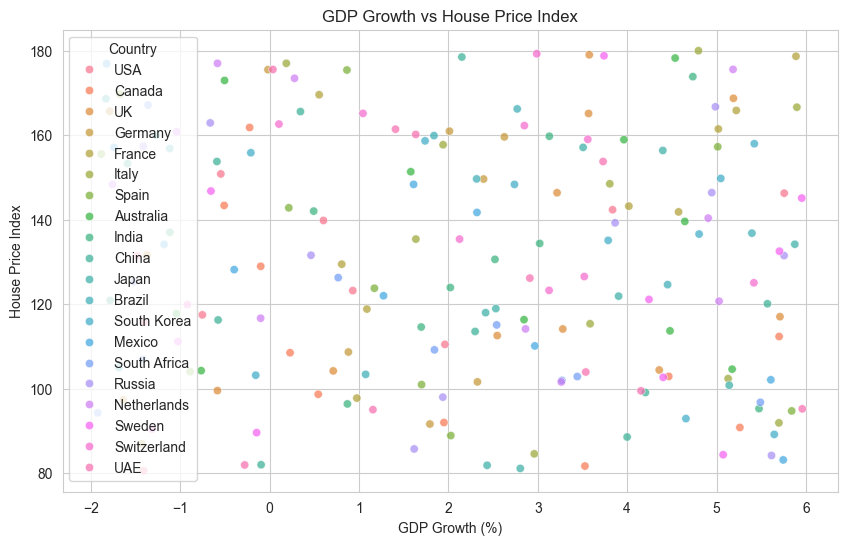

In [14]:
# Economic Growth Impact
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='GDP Growth (%)', y='House Price Index', hue='Country', alpha=0.7)
plt.title("GDP Growth vs House Price Index")
plt.xlabel("GDP Growth (%)")
plt.ylabel("House Price Index")
plt.show()

In [15]:
# Correlation between GDP Growth and House Price Index
correlation = data[['GDP Growth (%)', 'House Price Index']].corr().iloc[0, 1]
print(f"Correlation between GDP Growth and House Price Index: {correlation:.2f}")

Correlation between GDP Growth and House Price Index: -0.08


## Correlation & Relationships
- House Price vs. Rent Index
- Affordability vs. Economic Indicators
- Construction Index vs. Housing Market

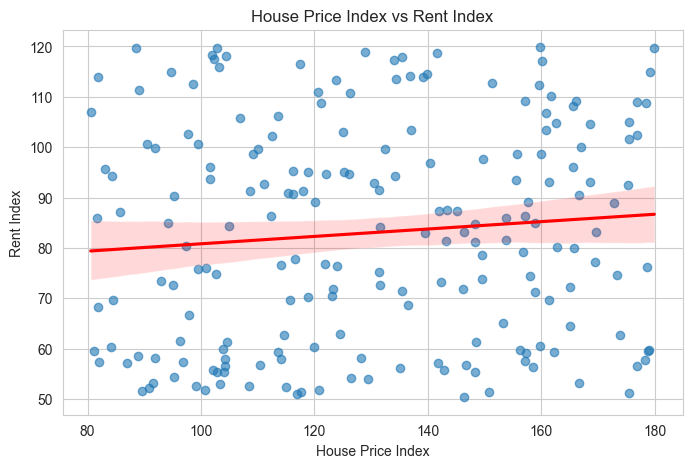

Correlation between House Price Index and Rent Index: 0.10


In [16]:
# House Price vs. Rent Index
plt.figure(figsize=(8, 5))
sns.regplot(data=data, x='House Price Index', y='Rent Index', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title("House Price Index vs Rent Index")
plt.xlabel("House Price Index")
plt.ylabel("Rent Index")
plt.show()

correlation_price_rent = data[['House Price Index', 'Rent Index']].corr().iloc[0, 1]
print(f"Correlation between House Price Index and Rent Index: {correlation_price_rent:.2f}")

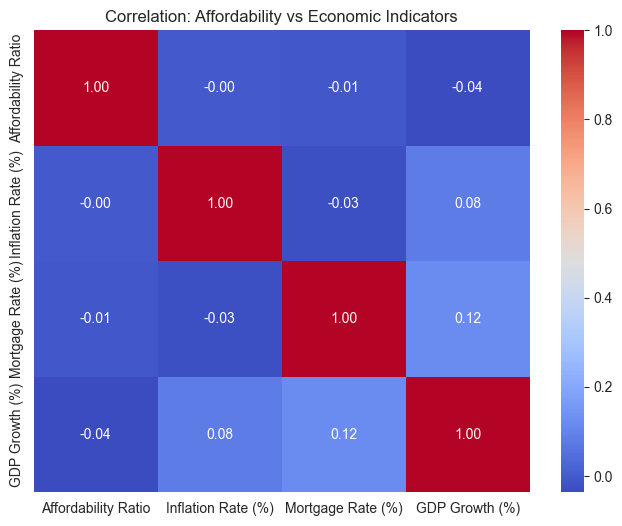

In [17]:
# Affordability vs Economic Indicators
economic_factors = ['Affordability Ratio', 'Inflation Rate (%)', 'Mortgage Rate (%)', 'GDP Growth (%)']
correlation_matrix = data[economic_factors].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Affordability vs Economic Indicators")
plt.show()

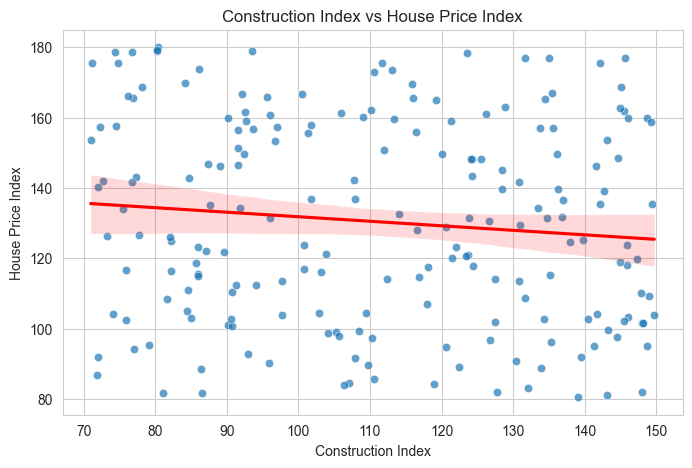

Correlation between Construction Index and House Price Index: -0.11


In [18]:
# Construction Index vs Housing Market
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='Construction Index', y='House Price Index', alpha=0.7)
sns.regplot(data=data, x='Construction Index', y='House Price Index', scatter=False, line_kws={'color':'red'})
plt.title("Construction Index vs House Price Index")
plt.xlabel("Construction Index")
plt.ylabel("House Price Index")
plt.show()

correlation_construction_price = data[['Construction Index', 'House Price Index']].corr().iloc[0, 1]
print(f"Correlation between Construction Index and House Price Index: {correlation_construction_price:.2f}")

## Statistical Test Between Features

- Spearman Rank Correlation (for non-linear relationships)
- T-Test: Comparing Affordability in Two Time Periods
- ANOVA
- Granger Causality Test
- Chi-Square Test: Is House Price Growth Linked to Urbanization?
- Durbin-Watson Test for Autocorrelation in House Price Trends

In [20]:
# # Choose specific countries for analysis (optional)
# selected_countries = ["USA", "Canada", "Germany"]  # Modify as needed
# df_selected = data[data["Country"].isin(selected_countries)]

# Spearman Rank Correlation (for non-linear relationships)
spearman_corr = data[['House Price Index', 'Rent Index']].corr(method='spearman').iloc[0, 1]
print(f"\n Spearman Correlation (House Price Index vs Rent Index): {spearman_corr:.2f}")
if abs(spearman_corr) > 0.7:
    print(" Strong non-linear relationship detected!")
elif abs(spearman_corr) > 0.3:
    print("Moderate non-linear relationship detected.")
else:
    print("Weak relationship; rent and house prices may not be directly linked.")


 Spearman Correlation (House Price Index vs Rent Index): 0.10
Weak relationship; rent and house prices may not be directly linked.


In [23]:
# T-Test: Comparing Affordability in Two Time Periods
data['Period'] = data['Year'].apply(lambda x: '2015-2019' if x < 2020 else '2020-2024')

# Perform t-test
group1 = data[data['Period'] == '2015-2019']['Affordability Ratio']
group2 = data[data['Period'] == '2020-2024']['Affordability Ratio']
t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"\n T-Test for Affordability (2015-2019 vs 2020-2024)")
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference: Affordability changed over time.")
else:
    print("No significant change in affordability.")


 T-Test for Affordability (2015-2019 vs 2020-2024)
T-Statistic: 0.10, P-Value: 0.9191
No significant change in affordability.


In [24]:
# ANOVA: House Price Index Across Countries
anova_result = stats.f_oneway(
    *[data[data['Country'] == country]['House Price Index'] for country in selected_countries]
)
print(f"\n ANOVA Test for House Price Index Across Countries")
print(f"F-Statistic: {anova_result.statistic:.2f}, P-Value: {anova_result.pvalue:.4f}")
if anova_result.pvalue < 0.05:
    print("Significant variation in house prices between countries.")
else:
    print("No significant difference in house prices across countries.")


 ANOVA Test for House Price Index Across Countries
F-Statistic: 1.77, P-Value: 0.1891
No significant difference in house prices across countries.


In [25]:
df_causal = data[['Year', 'House Price Index', 'GDP Growth (%)', 'Inflation Rate (%)', 'Mortgage Rate (%)']]
df_causal = df_causal.groupby('Year').mean().dropna()

# Granger Causality Test: Do Economic Indicators Predict House Prices?
max_lags = 2
print("\n Granger Causality Test Results:")
for col in ['GDP Growth (%)', 'Inflation Rate (%)', 'Mortgage Rate (%)']:
    test_result = grangercausalitytests(df_causal[['House Price Index', col]], max_lags, verbose=False)
    p_value = test_result[max_lags][0]['ssr_ftest'][1]  # Extract p-value
    print(f"🔹 {col} → House Price Index: P-Value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"{col} Granger-causes House Price Index (Statistically Significant)")
    else:
        print(f"No significant causal relationship between {col} and House Price Index.")


 Granger Causality Test Results:


c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Regression\Global Housing Market Analysis (2015-2024)\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Regression\Global Housing Market Analysis (2015-2024)\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


🔹 GDP Growth (%) → House Price Index: P-Value = 0.5275
No significant causal relationship between GDP Growth (%) and House Price Index.
🔹 Inflation Rate (%) → House Price Index: P-Value = 0.2752
No significant causal relationship between Inflation Rate (%) and House Price Index.
🔹 Mortgage Rate (%) → House Price Index: P-Value = 0.6405
No significant causal relationship between Mortgage Rate (%) and House Price Index.


c:\Users\User\Documents\Portfolio Projects\Learning-Portfolio-Projects\Python Projects\Regression\Global Housing Market Analysis (2015-2024)\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [26]:
# Chi-Square Test: Is House Price Growth Linked to Urbanization?
data['Urbanization Level'] = pd.qcut(data['Urbanization Rate (%)'], q=2, labels=['Low', 'High'])
data['Price Growth Category'] = pd.qcut(data['House Price Index'], q=2, labels=['Low', 'High'])

# Contingency table
contingency_table = pd.crosstab(data['Urbanization Level'], data['Price Growth Category'])
chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

print(f"\n Chi-Square Test for Urbanization vs House Price Growth")
print(f"Chi2 Statistic: {chi2_stat:.2f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant relationship: House price growth is linked to urbanization.")
else:
    print("No significant relationship between urbanization and house prices.")


 Chi-Square Test for Urbanization vs House Price Growth
Chi2 Statistic: 0.02, P-Value: 0.8875
No significant relationship between urbanization and house prices.


In [27]:
# Durbin-Watson Test for Autocorrelation in House Price Trends
df_price_trend = data.groupby('Year')['House Price Index'].mean().reset_index()
X = sm.add_constant(df_price_trend['Year'])
y = df_price_trend['House Price Index']
model = sm.OLS(y, X).fit()
dw_stat = durbin_watson(model.resid)

print(f"\n Durbin-Watson Test for Autocorrelation in House Price Index Residuals: {dw_stat:.2f}")
if dw_stat < 1.5:
    print("Possible positive autocorrelation in house price trends.")
elif dw_stat > 2.5:
    print("Possible negative autocorrelation in house price trends.")
else:
    print("No significant autocorrelation detected.")


 Durbin-Watson Test for Autocorrelation in House Price Index Residuals: 2.46
No significant autocorrelation detected.


In [88]:
data.columns

Index(['Country', 'Year', 'House Price Index', 'Rent Index',
       'Affordability Ratio', 'Mortgage Rate (%)', 'Inflation Rate (%)',
       'GDP Growth (%)', 'Population Growth (%)', 'Urbanization Rate (%)',
       'Construction Index'],
      dtype='object')

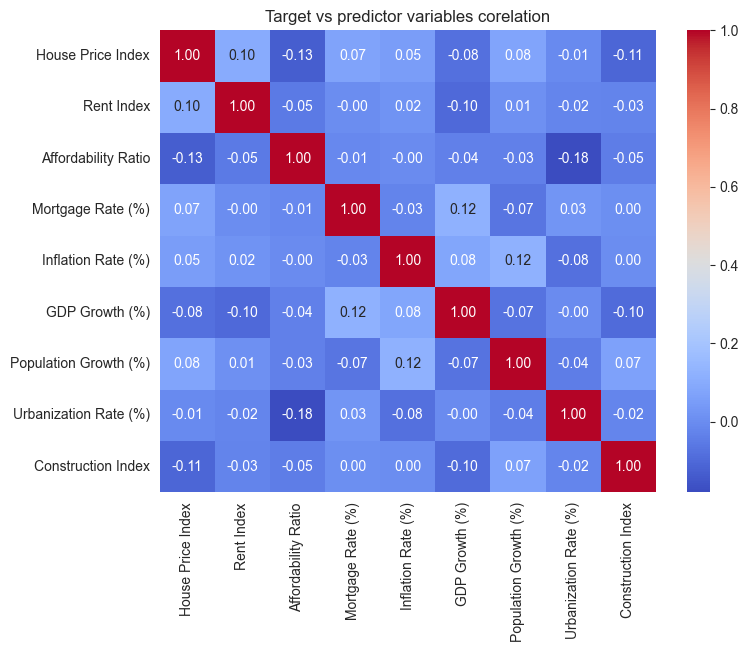

In [89]:
# Affordability vs Economic Indicators
features_col = ['House Price Index', 'Rent Index',
       'Affordability Ratio', 'Mortgage Rate (%)', 'Inflation Rate (%)',
       'GDP Growth (%)', 'Population Growth (%)', 'Urbanization Rate (%)',
       'Construction Index']
correlation_matrix = data[features_col].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Target vs predictor variables corelation")
plt.show()

# Model Building

## Feature Scalling

In [4]:
data_prep = data.copy()

In [5]:
numeric_cols = data_prep .select_dtypes(include=['float64', 'int64']).columns.drop(['House Price Index', 'Year'], errors='ignore')

scaler = StandardScaler()

scaled_features = scaler.fit_transform(data_prep [numeric_cols])

scaled_df = pd.DataFrame(scaled_features, columns=numeric_cols, index=data_prep.index)

data_prep [numeric_cols] = scaled_df

In [6]:
# Select relevant numerical features
features = ['Rent Index',
       'Affordability Ratio', 'Mortgage Rate (%)', 'Inflation Rate (%)',
       'GDP Growth (%)', 'Population Growth (%)', 'Urbanization Rate (%)',
       'Construction Index']
target = 'House Price Index'

In [7]:
# Split dataset
X = data_prep[features]
y = data_prep[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

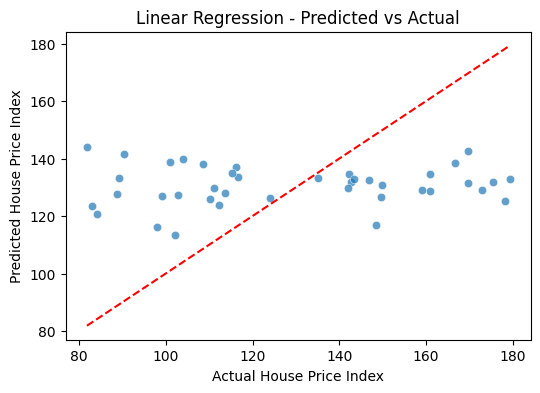

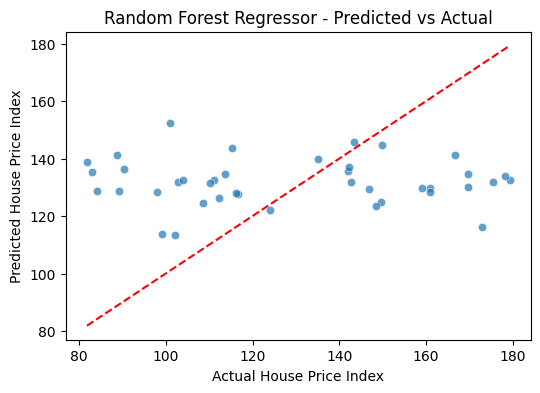

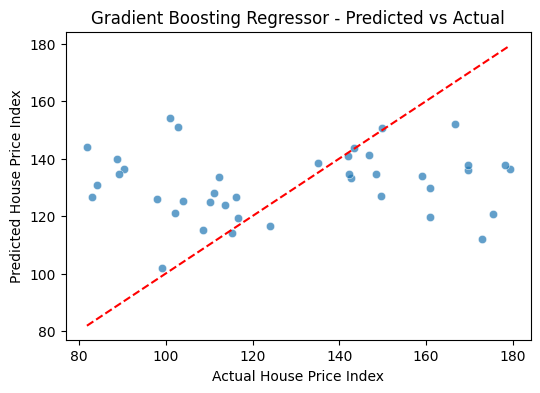

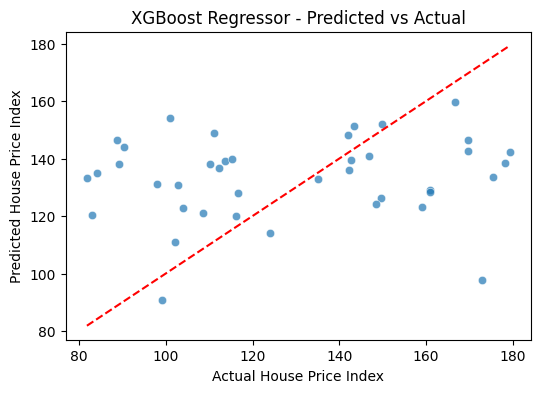


 Model Performance Summary:
                         Model        MAE       RMSE  R² Score
0            Linear Regression  26.918329  30.508147 -0.010138
2  Gradient Boosting Regressor  24.994177  31.401342 -0.070152
1      Random Forest Regressor  27.253969  31.698016 -0.090469
3            XGBoost Regressor  26.505132  32.109136 -0.118939


In [7]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train models & evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R² Score": r2})
    
    # Plot predicted vs actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual House Price Index")
    plt.ylabel("Predicted House Price Index")
    plt.title(f"{name} - Predicted vs Actual")
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n Model Performance Summary:")
print(results_df.sort_values(by="R² Score", ascending=False))


## Recursive Feature Elimination

In [8]:
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=3)
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("\n Selected Features:", list(selected_features))


 Selected Features: ['Mortgage Rate (%)', 'GDP Growth (%)', 'Construction Index']


## Re Run Models (With selected features)

In [9]:
# Split dataset
X = data_prep[selected_features]
y = data_prep[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape, X_test.shape

((160, 3), (40, 3))

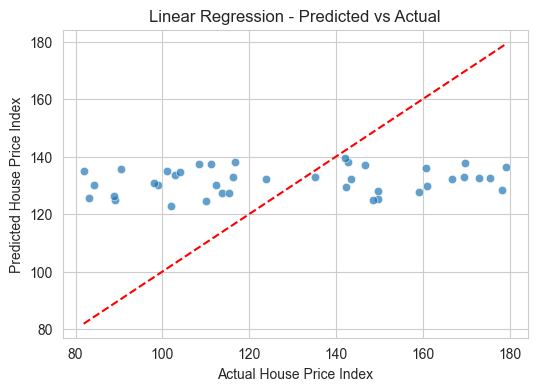

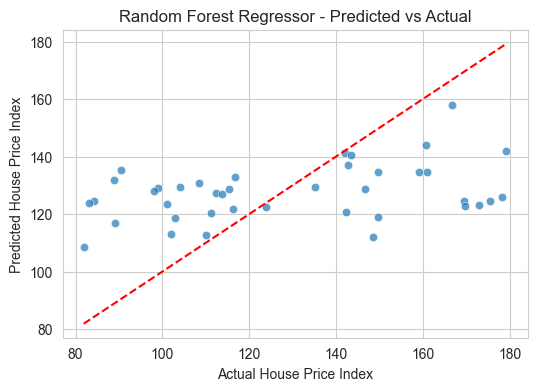

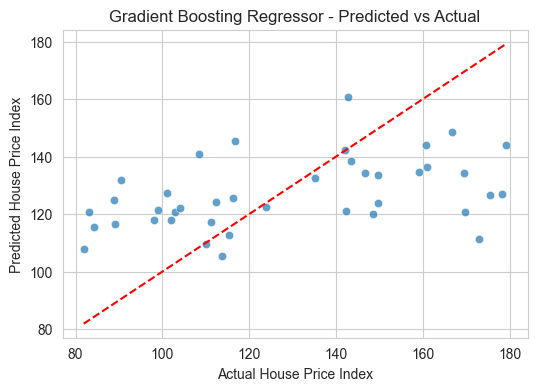

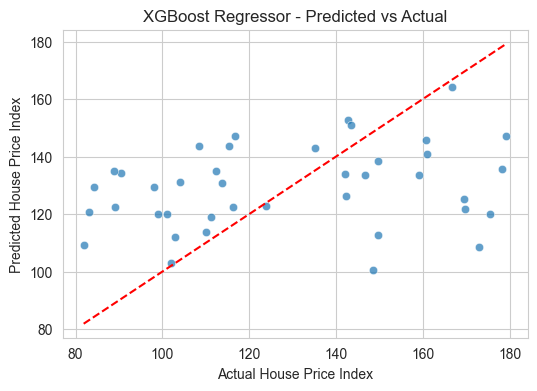


 Model Performance Summary (After Recursive Feature Elimination):
                         Model        MAE       RMSE  R² Score
2  Gradient Boosting Regressor  22.899973  27.271077  0.192851
1      Random Forest Regressor  23.776672  28.190971  0.137480
3            XGBoost Regressor  25.090498  29.996586  0.023454
0            Linear Regression  26.961771  30.049300  0.020019


In [14]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train models & evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R² Score": r2})

    # Plot predicted vs actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual House Price Index")
    plt.ylabel("Predicted House Price Index")
    plt.title(f"{name} - Predicted vs Actual")
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n Model Performance Summary (After Recursive Feature Elimination):")
print(results_df.sort_values(by="R² Score", ascending=False))